# Fluid Logo

This example shows how to run a simple fluid simulation with inflows and obstacles.

- https://tum-pbs.github.io/PhiFlow/examples/grids/Fluid_Logo.html

In [ ]:
from phi.jax.flow import *

Let's begin by defining the resolution and size of our domain, as well as the obstacle geometries.
We build a complex obstacle geometry out of multiple boxes here.

In [ ]:
domain = dict(x=128, y=128, bounds=Box(x=100, y=100))
geometries = [Box(x=(15 + x * 7, 15 + (x + 1) * 7), y=(41, 83)) for x in range(1, 10, 2)] + [Box['x,y', 43:50, 41:48], Box['x,y', 15:43, 83:90], Box['x,y', 50:85, 83:90]]
geometry = union(geometries)

Let's plot the obstacle! For the right plot, we sample the geometry on a grid matching our simulation settings. The simulation will only use the sampled version. If you have thin geometries, make sure that they don't result in holes after resampling!



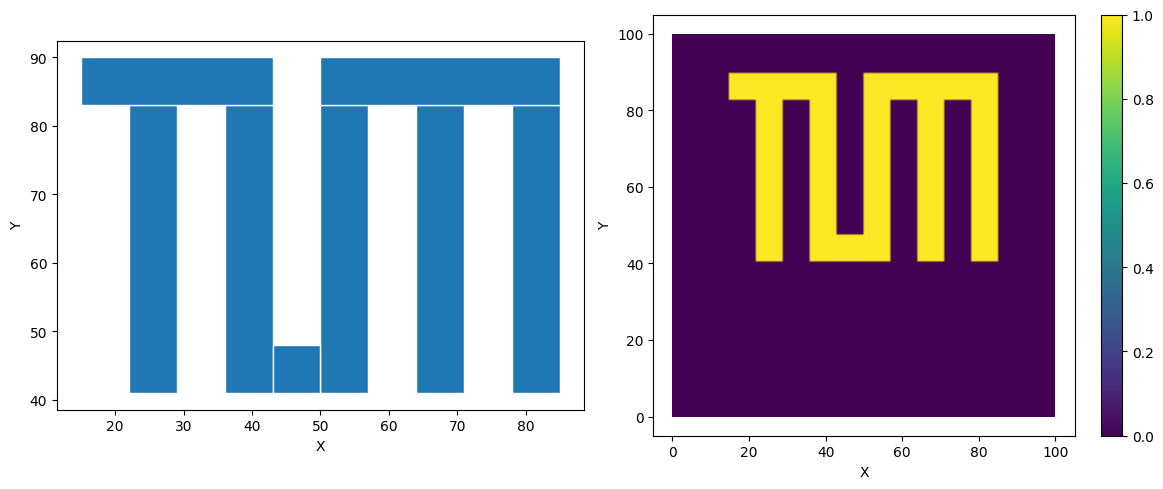

In [ ]:
plot(geometry, CenteredGrid(geometry, 0, **domain));

Next, we define three smoke inflows for our simulation and sample them on a grid.

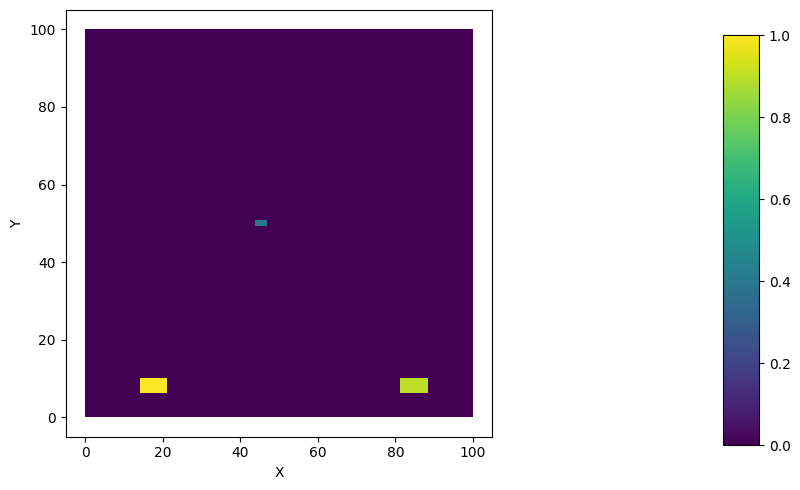

In [ ]:
inflow = CenteredGrid(Box(x=(14, 21), y=(6, 10)), ZERO_GRADIENT, **domain) + \
         CenteredGrid(Box(x=(81, 88), y=(6, 10)), ZERO_GRADIENT, **domain) * 0.9 + \
         CenteredGrid(Box(x=(44, 47), y=(49, 51)), ZERO_GRADIENT, **domain) * 0.4
plot(inflow);

Finally, we define the simulation.
We let the smoke apply an upwards `buoyancy_force` on the velocity proportional to its density.
As we sample the velocity on a staggered grid but the smoke density on a centered grid, we need to resample the force to the staggered grid.
Passing the obstacle to `make_incompressible` ensures that that no fluid can flow into or out of the defined geometry.

In [ ]:
@jit_compile
def step(smoke, v, pressure, inflow, dt=1.):
    smoke = advect.semi_lagrangian(smoke, v, 1) + inflow
    buoyancy_force = resample(smoke * (0, 0.1), to=v)
    v = advect.semi_lagrangian(v, v, 1) + buoyancy_force
    v, pressure = fluid.make_incompressible(v, geometry, Solve('CG-adaptive', 1e-5, x0=pressure))
    return smoke, v, pressure

v0 = StaggeredGrid(0, boundary=0, **domain)
smoke0 = CenteredGrid(0, boundary=ZERO_GRADIENT, **domain)
smoke_trj, v_trj, pressure_trj = iterate(step, batch(time=200), smoke0, v0, None, inflow=inflow)

Note that passing `batch(time=200)` to `iterate` stacks the variables along a new dimension called `time`.
This allows us to easily animate the result.

In [ ]:
smoke_trj

Grid[(timeᵇ=201, xˢ=128, yˢ=128) 0.396 ± 0.809 (0e+00...9e+00), ext=zero-gradient]

In [ ]:
smoke_trj.time[::2]

Grid[(timeᵇ=101, xˢ=128, yˢ=128) 0.396 ± 0.809 (0e+00...9e+00), ext=zero-gradient]

In [ ]:
plot(smoke_trj.time[::2], animate='time')

<Figure size 640x480 with 0 Axes>